# Initialization

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt, matplotlib.dates as mdates

In [2]:
import matplotlib as mpl
#mpl.rcParams.update(mpl.rcParamsDefault)
mpl.rcParams.update({'font.size': 20, 'lines.linewidth': 3, 'lines.markersize': 15, 'figure.figsize': (11.7, 8.27)}) #
mpl.rcParams['ps.useafm'] = True
mpl.rcParams['pdf.use14corefonts'] = True

In [3]:
!pip install factor_analyzer  
from factor_analyzer import FactorAnalyzer, calculate_bartlett_sphericity, calculate_kmo

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
#%cd drive/MyDrive/Github/master_thesis
%cd drive/MyDrive/GitHub/master-thesis
from clustering.utils import *

/content/drive/MyDrive/GitHub/master-thesis


In [6]:
def cronbach_alpha(df):
    df_corr = df.corr()

    N = df.shape[1]

    rs = np.array([])
    for i, col in enumerate(df_corr.columns):
        sum_ = df_corr[col][i+1:].values
        rs = np.append(sum_, rs)
    mean_r = np.mean(rs)
    
    cronbach_alpha = (N * mean_r) / (1 + (N - 1) * mean_r)
    return cronbach_alpha

# Preprocessing

In [7]:
beh_cols = get_behaviour_cols()
df_fa_input = get_preprocessed_data(impute=True, impute_cols=beh_cols, start='2020-07-21', end='2021-02-01')

In [8]:
# Train Test Split
start_train = '2020-08-01'
end_train = '2020-12-01'
df_fa_input_train = df_fa_input[(df_fa_input.date >= start_train) & (df_fa_input.date < end_train)]
min(df_fa_input_train.date)

Timestamp('2020-08-01 00:00:00')

In [9]:
scaler = MinMaxScaler()
fa_input_train = scaler.fit_transform(df_fa_input_train[beh_cols].to_numpy())
fa_input = scaler.fit_transform(df_fa_input[beh_cols].to_numpy())
df_fa_input_scaled = pd.DataFrame(data=fa_input, columns=beh_cols)
fa_input.shape

(50139, 30)

# Check requirements
ref: Klaus Backhaus et al. Multivariate analysemethoden. Springer, 2021, pp. 413–488

1. Bartlett’s test (test for sphericity)

In [10]:
# P Value should be smaller 0.05
statistic, p_value = calculate_bartlett_sphericity(fa_input_train)
print(statistic, p_value)

303506.7595592169 0.0


In [11]:
p_value

0.0

2. Kaiser-Meyer-Olkin (KMO)

In [12]:
#KMO should be greater or equal to 0.5
kmo_per_item, kmo_total = calculate_kmo(fa_input_train)
kmo_total

/usr/local/lib/python3.7/dist-packages/factor_analyzer/utils.py:249: UserWarning: The inverse of the variance-covariance matrix was calculated using the Moore-Penrose generalized matrix inversion, due to its determinant being at or very close to zero.
  warnings.warn('The inverse of the variance-covariance matrix '


0.8983678398666868

3. Measure of Sampling Adequacy (MSA)

In [13]:
kmo_per_item

array([0.81051002, 0.90400621, 0.89411907, 0.8519467 , 0.92095261,
       0.88210971, 0.68339177, 0.76079488, 0.91563803, 0.9349114 ,
       0.92834922, 0.95507226, 0.93253289, 0.92541962, 0.90613339,
       0.92038679, 0.76982661, 0.76547366, 0.70049497, 0.93510783,
       0.79688062, 0.77228495, 0.92865881, 0.87715083, 0.94049997,
       0.94107117, 0.93802345, 0.74006202, 0.92964364, 0.92325248])

In [14]:
(kmo_per_item < 0.5).sum()

0

4. Anti-image covariance matrix

In [15]:
# calc anti-image covariance matrix
R = np.corrcoef(fa_input_train, rowvar=False)
R_inv = np.linalg.inv(R)
temp = np.diagflat(R_inv.diagonal())
D = np.linalg.inv(temp)
anti_image_covariance_matrix = np.dot(np.dot(D, R_inv), D)

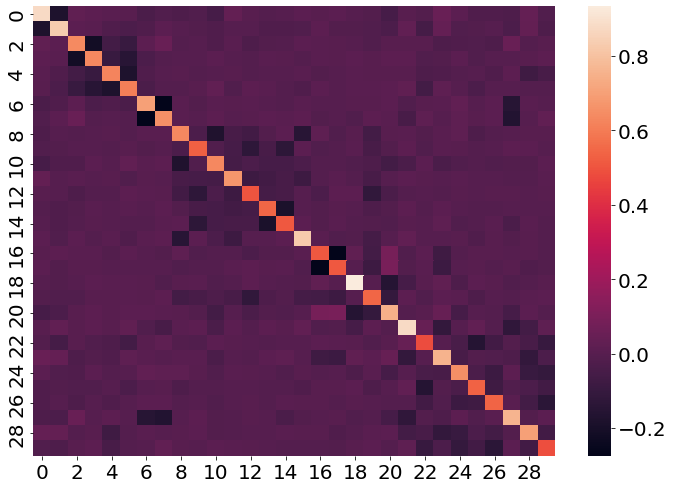

In [16]:
sns.heatmap(anti_image_covariance_matrix)
plt.show()

In [17]:
diff_zero_value = 0.03
num_non_diag_values_differ_from_zero = (anti_image_covariance_matrix > diff_zero_value).sum() + (anti_image_covariance_matrix < -diff_zero_value).sum() - anti_image_covariance_matrix.shape[0]
num_non_diag_values = anti_image_covariance_matrix.shape[0]**2 - - anti_image_covariance_matrix.shape[0]
percentage = num_non_diag_values_differ_from_zero / num_non_diag_values * 100
percentage

20.86021505376344

# Factor Analysis

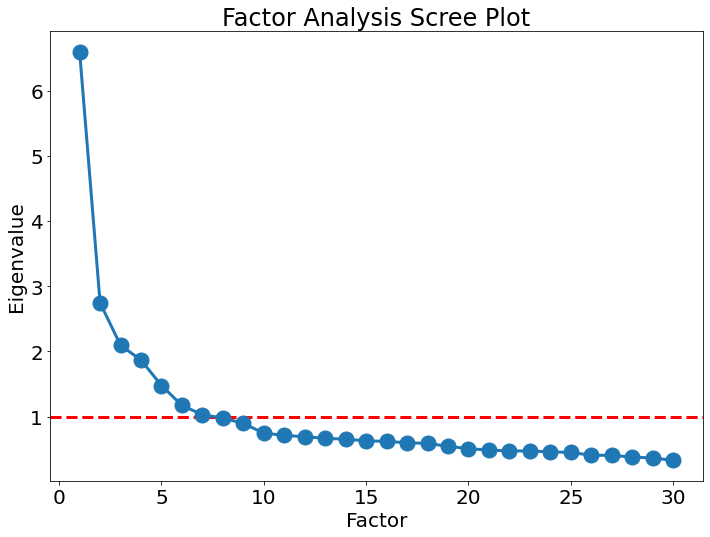

In [18]:
fa = FactorAnalyzer(rotation=None)
fa.fit(fa_input_train)
#Get Eigen values and plot them
ev, v = fa.get_eigenvalues()
plt.title('Factor Analysis Scree Plot')
plt.xlabel('Factor')
plt.ylabel('Eigenvalue')
plt.axhline(y=1, color='r', linestyle='dashed')
plt.plot(range(1,fa_input_train.shape[1]+1),ev, marker='o')
plt.savefig('images/scree_plot_factor_analysis.png')

In [19]:
ev

array([6.59884919, 2.74364642, 2.09279878, 1.86589592, 1.47557162,
       1.1702444 , 1.02804343, 0.97722604, 0.89399591, 0.74492427,
       0.71070935, 0.68924582, 0.66641001, 0.65075528, 0.62718519,
       0.61825062, 0.59696539, 0.58760079, 0.54315096, 0.5070665 ,
       0.48444904, 0.47241583, 0.47056404, 0.4582041 , 0.44778704,
       0.40607299, 0.40376749, 0.37722604, 0.3640874 , 0.32689011])

In [20]:
num_factors_one = (ev > 1).sum()
num_factors_avg = (ev > ev.mean()).sum()
explained_variance = ev[:num_factors_one].sum() / ev.sum()
print(f'Es gibt {num_factors_one} Eigenwerte, die größer als eins sind und {num_factors_avg} Eigenwerte, die größer als der Durchschnitt sind. Damit werden {round(explained_variance * 100, 3)} % der Varianz erklärt.')

Es gibt 7 Eigenwerte, die größer als eins sind und 7 Eigenwerte, die größer als der Durchschnitt sind. Damit werden 56.583 % der Varianz erklärt.


In [21]:
n_factor = 6
fa = FactorAnalyzer(n_factor, rotation='varimax')
fa.fit(fa_input_train)
loads = fa.loadings_

# Evaluate Factors

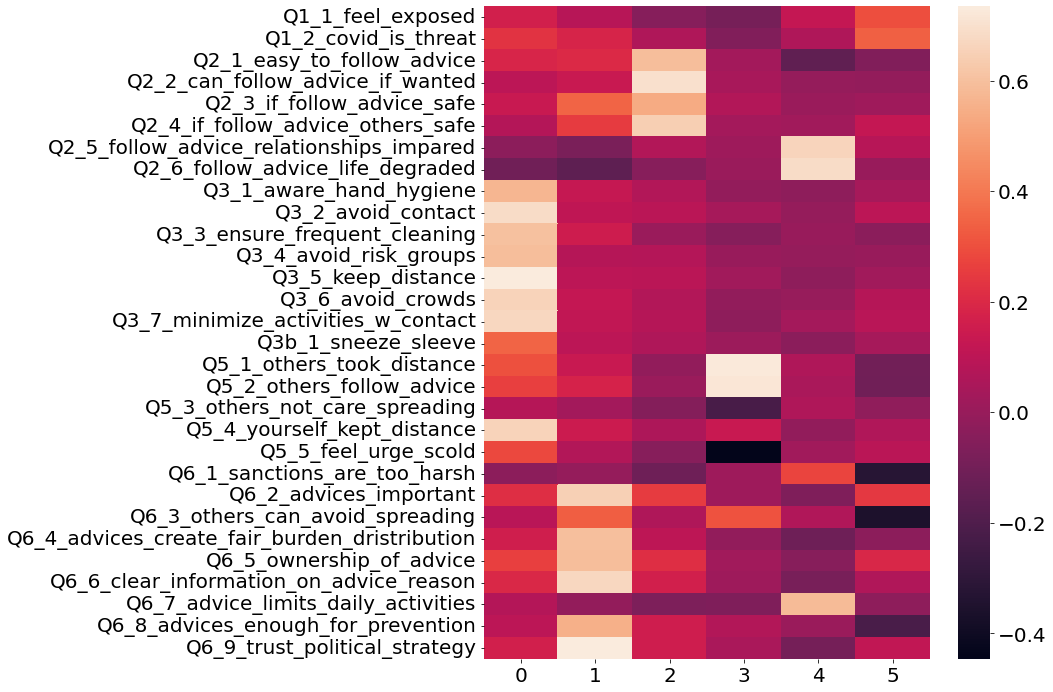

In [22]:
fig, ax = plt.subplots(figsize=(10, 12))
heatmap_data = pd.DataFrame(loads.T, columns=beh_cols).T
sns.heatmap(heatmap_data, ax=ax)
#fig = heatmap_loadings.get_figure()
#fig.savefig("images/heatmap_factor_loadings.png")
plt.show()

In [23]:
heatmap_data

,0,1,2,3,4,5
Q1_1_feel_exposed,0.166958,0.085031,-0.046503,-0.088397,0.124403,0.300402
Q1_2_covid_is_threat,0.231437,0.181054,0.061310,-0.063180,0.064942,0.338774
Q2_1_easy_to_follow_advice,0.187835,0.201967,0.591702,0.029645,-0.153725,-0.059887
Q2_2_can_follow_advice_if_wanted,0.098919,0.135025,0.698225,0.046896,-0.003519,-0.009014
Q2_3_if_follow_advice_safe,0.134785,0.350007,0.536361,0.072671,0.008189,0.021758
Q2_4_if_follow_advice_others_safe,0.079108,0.254041,0.646044,0.033616,0.024800,0.124504
Q2_5_follow_advice_relationships_impared,-0.030385,-0.080676,0.074623,0.015460,0.664228,0.084202
Q2_6_follow_advice_life_degraded,-0.109349,-0.158232,-0.041475,0.008293,0.685966,0.001878
Q3_1_aware_hand_hygiene,0.569101,0.127677,0.072284,-0.011428,-0.023421,0.040831
Q3_2_avoid_contact,0.684956,0.110636,0.096988,0.039681,-0.005097,0.100442


In [24]:
dict_fa = {}
for i in np.arange(n_factor):
  col_names = heatmap_data[heatmap_data[i].abs() >= 0.5][i].index.tolist()
  df_factor = df_fa_input_scaled[col_names]
  factor_alpha = cronbach_alpha(df_factor)
  temp_dict = {'Factor_Names': col_names, 'Data': df_factor, 'Cronbach_Alpha': factor_alpha}
  print(f'Factor {i} with Columns {col_names} has a Cronbachs Alpha of {factor_alpha}')
  dict_fa.update({i: temp_dict})

Factor 0 with Columns ['Q3_1_aware_hand_hygiene', 'Q3_2_avoid_contact', 'Q3_3_ensure_frequent_cleaning', 'Q3_4_avoid_risk_groups', 'Q3_5_keep_distance', 'Q3_6_avoid_crowds', 'Q3_7_minimize_activities_w_contact', 'Q5_4_yourself_kept_distance'] has a Cronbachs Alpha of 0.8653181951090738
Factor 1 with Columns ['Q6_2_advices_important', 'Q6_4_advices_create_fair_burden_dristribution', 'Q6_5_ownership_of_advice', 'Q6_6_clear_information_on_advice_reason', 'Q6_8_advices_enough_for_prevention', 'Q6_9_trust_political_strategy'] has a Cronbachs Alpha of 0.8428172654509242
Factor 2 with Columns ['Q2_1_easy_to_follow_advice', 'Q2_2_can_follow_advice_if_wanted', 'Q2_3_if_follow_advice_safe', 'Q2_4_if_follow_advice_others_safe'] has a Cronbachs Alpha of 0.769212135397822
Factor 3 with Columns ['Q5_1_others_took_distance', 'Q5_2_others_follow_advice'] has a Cronbachs Alpha of 0.8060147031945462
Factor 4 with Columns ['Q2_5_follow_advice_relationships_impared', 'Q2_6_follow_advice_life_degraded', 'Q

/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [25]:
col_names = ['Q1_1_feel_exposed', 'Q1_2_covid_is_threat', 'Q6_1_sanctions_are_too_harsh', 'Q6_3_others_can_avoid_spreading']
df_fa_input_scaled[col_names].describe()

,Q1_1_feel_exposed,Q1_2_covid_is_threat,Q6_1_sanctions_are_too_harsh,Q6_3_others_can_avoid_spreading
count,50139.000000,50139.000000,50139.000000,50139.000000
mean,0.378426,0.670339,0.359330,0.575465
std,0.299501,0.288739,0.297148,0.259870
min,0.000000,0.000000,0.000000,0.000000
25%,0.166667,0.500000,0.000000,0.500000
50%,0.333333,0.666667,0.333333,0.500000
75%,0.500000,1.000000,0.500000,0.833333
max,1.000000,1.000000,1.000000,1.000000


In [26]:
df_fa_input_scaled['Q6_1_sanctions_are_too_harsh'] = df_fa_input_scaled['Q6_1_sanctions_are_too_harsh'] * (-1) + 1
df_fa_input_scaled['Q6_3_others_can_avoid_spreading'] = df_fa_input_scaled['Q6_3_others_can_avoid_spreading'] * (-1) + 1
df_fa_input_scaled[col_names].describe()

,Q1_1_feel_exposed,Q1_2_covid_is_threat,Q6_1_sanctions_are_too_harsh,Q6_3_others_can_avoid_spreading
count,50139.000000,50139.000000,5.013900e+04,5.013900e+04
mean,0.378426,0.670339,6.406699e-01,4.245352e-01
std,0.299501,0.288739,2.971484e-01,2.598696e-01
min,0.000000,0.000000,1.110223e-16,1.110223e-16
25%,0.166667,0.500000,5.000000e-01,1.666667e-01
50%,0.333333,0.666667,6.666667e-01,5.000000e-01
75%,0.500000,1.000000,1.000000e+00,5.000000e-01
max,1.000000,1.000000,1.000000e+00,1.000000e+00


In [27]:
cronbach_alpha(df_fa_input_scaled[['Q1_1_feel_exposed', 'Q1_2_covid_is_threat', 'Q6_1_sanctions_are_too_harsh', 'Q6_3_others_can_avoid_spreading']])

0.3096366346127718

# Create new factors

In [28]:
dict_combination = get_dict_combination()
factor_cols = get_factor_cols()
factor_cols

['F0_cautious_behaviour',
 'F1_perception_advice',
 'F2_applicability_usefullness_advice',
 'F3_behaviour_others',
 'F4_consequence_advice']

## Regression based approach

In [29]:
new_variables = fa.transform(fa_input)
df_fa_regression = pd.DataFrame(new_variables, columns=factor_cols)
df_fa_regression.dropna().info()

ValueError: ignored

## Mean based approach

In [30]:
df_fa_mean = pd.DataFrame()
for key in dict_combination:
  temp_cols = dict_combination[key]
  df_fa_mean[key] = df_fa_input_scaled[temp_cols].mean(axis=1)

In [31]:
df_fa_mean.describe()

,F0_cautious_behaviour,F1_perception_advice,F2_applicability_usefullness_advice,F3_behaviour_others,F4_consequence_advice
count,50139.000000,50139.000000,50139.000000,50139.000000,50139.000000
mean,0.798658,0.708580,0.782740,0.608593,0.506866
std,0.170030,0.201136,0.208931,0.229570,0.251421
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.708333,0.583333,0.708333,0.500000,0.333333
50%,0.833333,0.750000,0.833333,0.608593,0.500000
75%,0.937500,0.861111,0.958333,0.750000,0.666667
max,1.000000,1.000000,1.000000,1.000000,1.000000


In [32]:
df_fa_mean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50139 entries, 0 to 50138
Data columns (total 5 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   F0_cautious_behaviour                50139 non-null  float64
 1   F1_perception_advice                 50139 non-null  float64
 2   F2_applicability_usefullness_advice  50139 non-null  float64
 3   F3_behaviour_others                  50139 non-null  float64
 4   F4_consequence_advice                50139 non-null  float64
dtypes: float64(5)
memory usage: 1.9 MB


In [33]:
df_fa_input.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50139 entries, 0 to 50138
Data columns (total 80 columns):
 #   Column                                         Non-Null Count  Dtype         
---  ------                                         --------------  -----         
 0   gender                                         50139 non-null  int64         
 1   postnr                                         50139 non-null  int64         
 2   region                                         50139 non-null  object        
 3   Q1_1_feel_exposed                              50139 non-null  float64       
 4   Q1_2_covid_is_threat                           50139 non-null  float64       
 5   Q2_1_easy_to_follow_advice                     50139 non-null  float64       
 6   Q2_2_can_follow_advice_if_wanted               50139 non-null  float64       
 7   Q2_3_if_follow_advice_safe                     50139 non-null  float64       
 8   Q2_4_if_follow_advice_others_safe              50139 non

#Combine with original data

In [34]:
subset_drop = factor_cols + ['date']
df_fa_write = pd.concat([df_fa_mean, df_fa_input], axis=1)
df_fa_write.dropna(subset=subset_drop, inplace=True)
df_fa_write_save = df_fa_write.copy()
df_fa_write[subset_drop].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50139 entries, 0 to 50138
Data columns (total 6 columns):
 #   Column                               Non-Null Count  Dtype         
---  ------                               --------------  -----         
 0   F0_cautious_behaviour                50139 non-null  float64       
 1   F1_perception_advice                 50139 non-null  float64       
 2   F2_applicability_usefullness_advice  50139 non-null  float64       
 3   F3_behaviour_others                  50139 non-null  float64       
 4   F4_consequence_advice                50139 non-null  float64       
 5   date                                 50139 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(5)
memory usage: 2.7 MB


In [35]:
df_fa_modeling = df_fa_write[subset_drop].groupby('date').mean().reset_index()
#df_fa_modeling.to_csv('data/modeling/fa_data_model_input.csv', index=False)
df_fa_modeling.head()

,date,F0_cautious_behaviour,F1_perception_advice,F2_applicability_usefullness_advice,F3_behaviour_others,F4_consequence_advice
0,2020-07-21,0.749468,0.721376,0.811795,0.531591,0.415477
1,2020-07-22,0.744636,0.719618,0.787887,0.522827,0.447012
2,2020-07-23,0.721757,0.729743,0.781738,0.518931,0.413125
3,2020-07-24,0.738276,0.700628,0.778615,0.516830,0.443330
4,2020-07-25,0.749964,0.743679,0.784543,0.531305,0.423500


# Plot Factors

In [36]:
df_fa_write = df_fa_write[(df_fa_write.date >= '2020-08-01') & (df_fa_write.date < '2021-02-01')]

In [37]:
"""start = '2020-12-01'
end = '2020-12-14'
df_plot = df_fa_write.copy()
df_plot.date = pd.to_datetime(df_plot.date)
in_range = (df_plot.date > start) & (df_plot.date < end)
df_plot = df_plot[in_range]
df_plot = df_plot[factor_cols]
g = sns.PairGrid(data=df_plot)
g.map_upper(sns.scatterplot)
g.map_lower(sns.kdeplot)
g.map_diag(sns.kdeplot, lw=3, legend=False)"""

"start = '2020-12-01'\nend = '2020-12-14'\ndf_plot = df_fa_write.copy()\ndf_plot.date = pd.to_datetime(df_plot.date)\nin_range = (df_plot.date > start) & (df_plot.date < end)\ndf_plot = df_plot[in_range]\ndf_plot = df_plot[factor_cols]\ng = sns.PairGrid(data=df_plot)\ng.map_upper(sns.scatterplot)\ng.map_lower(sns.kdeplot)\ng.map_diag(sns.kdeplot, lw=3, legend=False)"

In [54]:
df_lineplot = df_fa_modeling[subset_drop]
df_lineplot = df_lineplot.groupby(by='date').mean().rolling(3).mean().reset_index()
df_lineplot = df_lineplot[(df_lineplot.date >= '2020-08-01') & (df_lineplot.date < '2021-02-01')]
df_lineplot

,date,F0_cautious_behaviour,F1_perception_advice,F2_applicability_usefullness_advice,F3_behaviour_others,F4_consequence_advice
11,2020-08-01,0.744578,0.724593,0.793887,0.513888,0.435239
12,2020-08-02,0.744518,0.727477,0.790175,0.530578,0.437782
13,2020-08-03,0.745206,0.724287,0.792306,0.535103,0.432638
14,2020-08-04,0.751699,0.723099,0.791174,0.542610,0.443402
15,2020-08-05,0.755465,0.723529,0.795416,0.527642,0.432438
...,...,...,...,...,...,...
190,2021-01-27,0.854032,0.737100,0.799307,0.665702,0.611219
191,2021-01-28,0.850039,0.732202,0.805799,0.668194,0.623767
192,2021-01-29,0.854373,0.736236,0.813281,0.666174,0.617807
193,2021-01-30,0.838274,0.717991,0.811286,0.666369,0.615552


In [55]:
# convert to long (tidy) form

df_lineplot_long = df_lineplot.melt('date', var_name='factor', value_name='values')
df_lineplot_long = df_lineplot_long[df_lineplot_long['values'].notna()].reset_index(drop=True)
df_lineplot_long['values'] = df_lineplot_long['values'] * 6 + 1
df_lineplot_long.date = pd.to_datetime(df_lineplot_long.date, format='%Y-%m-%d')
df_lineplot_long.head()

,date,factor,values
0,2020-08-01,F0_cautious_behaviour,5.467466
1,2020-08-02,F0_cautious_behaviour,5.467110
2,2020-08-03,F0_cautious_behaviour,5.471238
3,2020-08-04,F0_cautious_behaviour,5.510196
4,2020-08-05,F0_cautious_behaviour,5.532792


In [56]:
df_lineplot_long.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 920 entries, 0 to 919
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    920 non-null    datetime64[ns]
 1   factor  920 non-null    object        
 2   values  920 non-null    float64       
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 21.7+ KB


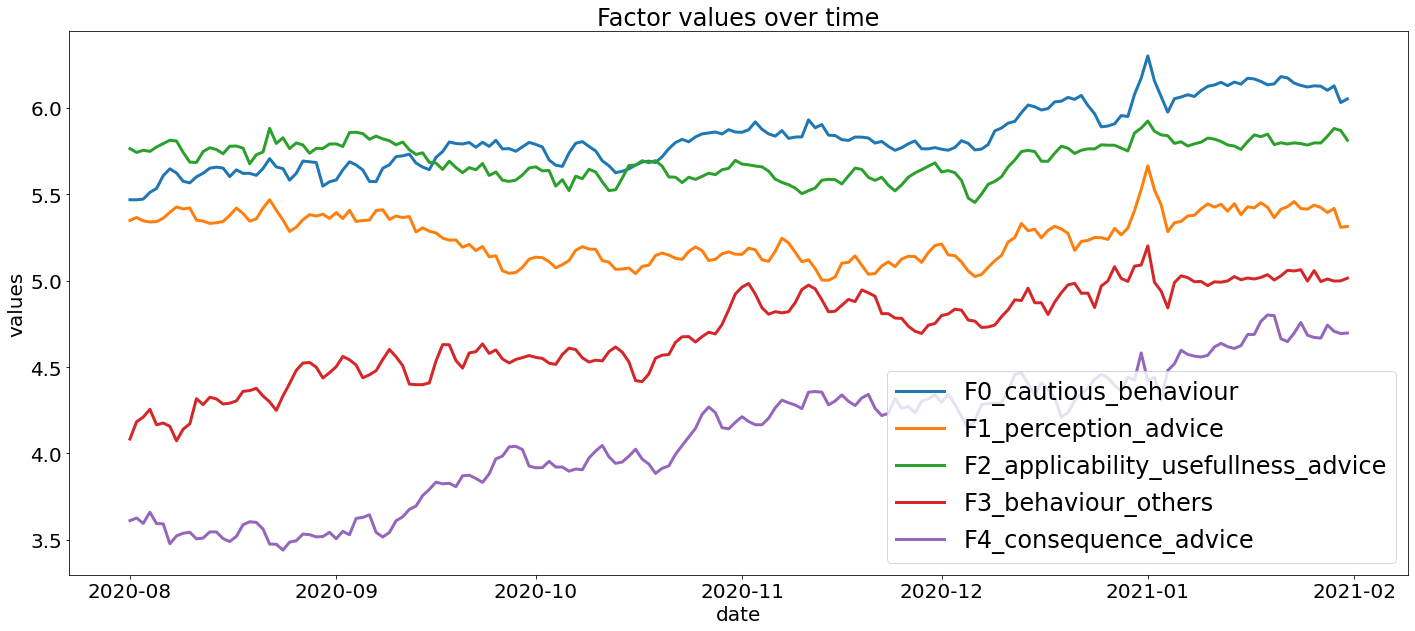

In [57]:
fig, ax = plt.subplots(figsize=(24, 10))
sns.lineplot(x="date", y="values", hue='factor', data=df_lineplot_long, ax=ax)
plt.title('Factor values over time')
ax.legend(loc='best', fontsize='large')
#fig.savefig("images/factor_values_lineplot.png")
plt.show()

In [ ]:
df_fa_write[subset_drop]

In [ ]:
df_distr = df_fa_write[factor_cols]
for col in factor_cols:
  df_distr.rename(columns={col: col[:2]}, inplace=True)
df_distr.describe()

In [ ]:
df_dist_plot = df_distr.melt(var_name='factor', value_name='values')
df_dist_plot['values'] = df_dist_plot['values'] * 6 + 1

In [ ]:
g = sns.FacetGrid(df_dist_plot, col="factor", height=4, aspect=0.75)
g.map(sns.histplot, "values", stat='percent', bins=7)
g.fig.subplots_adjust(top=0.8)
g.fig.suptitle('Histograms of Factors')
g.fig.savefig("images/factor_values_histplot.png")

In [ ]:
for col in factor_cols:
  fig, ax = plt.subplots(figsize=(10, 8))
  sns.lineplot(x="date", y=col, ci='sd', data=df_fa_write[subset_drop], ax=ax)
  ax.set_ylim([0, 1])
  fig.show()

# Write Data

In [ ]:
#df_fa_write_save.to_csv('data/preprocessing/dim_reduction/fa_data_experiments.csv', index=False)